In [1]:
import os
import cooler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
def extract_tss_from_bed(bed_file, genes_of_interest):
    """Extract TSS sites for target genes from BED file"""
    tss_list = []
    with open(bed_file, "r") as f:
        for line in f:
            cols = line.strip().split("\t")
            chrom, start, end, gene = cols[0], int(cols[1]), int(cols[2]), cols[3]
            if gene in genes_of_interest:
                tss_list.append((chrom, start, end, gene))
    return tss_list

# **Input Parameters**
bed_file = "../genome/hg38_promoters.bed"  # BED file
genes_of_interest = ["GATA6", "CTCF", "MYC"]  # Target genes

# **Extract TSS**
tss_list = extract_tss_from_bed(bed_file, genes_of_interest)

# **View extraction results**
pd.DataFrame(tss_list, columns=["Chromosome", "Start", "End", "Gene"])


,Chromosome,Start,End,Gene
0,chr8,127732934,127737934,MYC
1,chr16,67559967,67564967,CTCF
2,chr18,22166892,22171892,GATA6


In [6]:
def extract_hic_contact(cool_path, chrom, start, end, res):
    """Extract Hi-C matrix from .mcool file"""
    c = cooler.Cooler(f"{cool_path}::/resolutions/{res}")
    row_bin_start = (start // res) * res  # Calculate bin position
    left = max(0, row_bin_start - 250000)  # Extend 500kb to the left
    right = row_bin_start + 250000         # Extend 500kb to the right
    
    # Extract Contact Matrix
    mat_chr = c.matrix(balance=False, sparse=False).fetch((chrom, left, right))
    np.nan_to_num(mat_chr, copy=False)

    # Get Contact Frequency for target TSS bin
    row_index = (250000 // res)
    row_values = mat_chr[row_index, :] / mat_chr[row_index, row_index]
    row_values = row_values.tolist()

    # Calculate genomic coordinates
    genomic_coords = np.arange(left, right, res)

    return genomic_coords, row_values

In [8]:
def plot_virtual_4C(tss_list, res):
    """Plot Ctrl vs Aux Hi-C Contact Frequency for each gene"""
    # Define your two mcool files
    aux_file = "/Users/zoechen/Documents/Work/Yuelab/Projects/colon_cancer/HIC/DLD1-GATA6-aux-12h_220609-MboI-R1-filtered.mcool"
    ctrl_file = "/Users/zoechen/Documents/Work/Yuelab/Projects/colon_cancer/HIC/DLD1-GATA6-ctrl_220609-MboI-R1-filtered.mcool"

    # Ensure both files exist
    if not os.path.exists(aux_file) or not os.path.exists(ctrl_file):
        print(f"WARNING: {aux_file} or {ctrl_file} does not exist")
        return

    for chrom, start, end, gene in tss_list:
        # Get Hi-C Contact data
        genomic_coords_aux, contact_freqs_aux = extract_hic_contact(aux_file, chrom, start, end, res)
        genomic_coords_ctrl, contact_freqs_ctrl = extract_hic_contact(ctrl_file, chrom, start, end, res)

        # **Plot**
        plt.figure(figsize=(10, 6))
        plt.plot(genomic_coords_aux, contact_freqs_aux, label="Aux", alpha=0.7, color="green")
        plt.plot(genomic_coords_ctrl, contact_freqs_ctrl, label="Ctrl", alpha=0.7, color="red")

        # **Format image**
        plt.xlabel("Genomic Position (bp)", fontsize=12)
        plt.ylabel("Hi-C Contact Frequency", fontsize=12)
        plt.title(f"Virtual 4C - {gene}", fontsize=14, fontweight="bold")
        plt.ylim(-0.01, 1)
        plt.legend()
        plt.show()


Found 3 genes:
  MYC: chr8:127732934-127737934
  CTCF: chr16:67559967-67564967
  GATA6: chr18:22166892-22171892


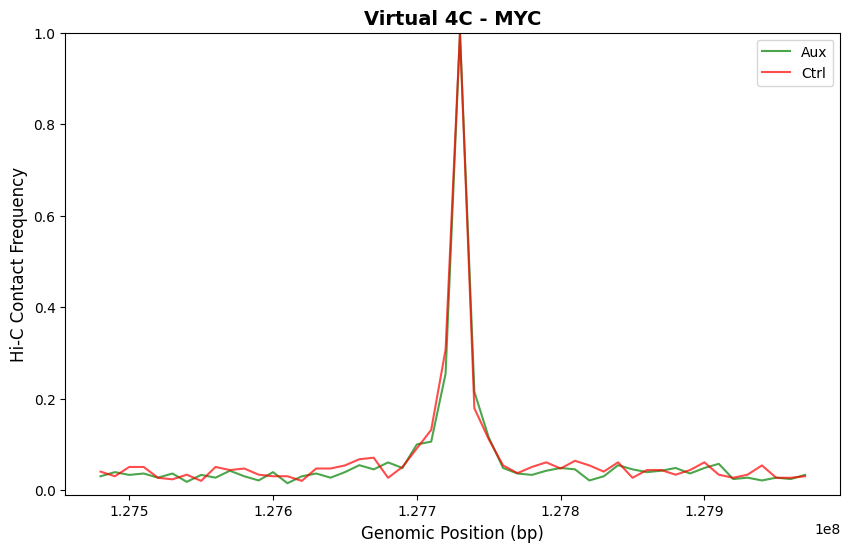

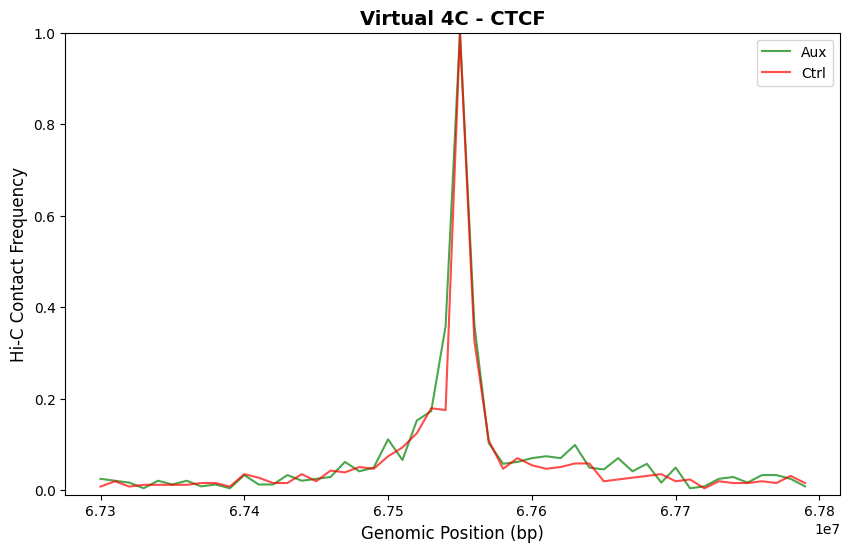

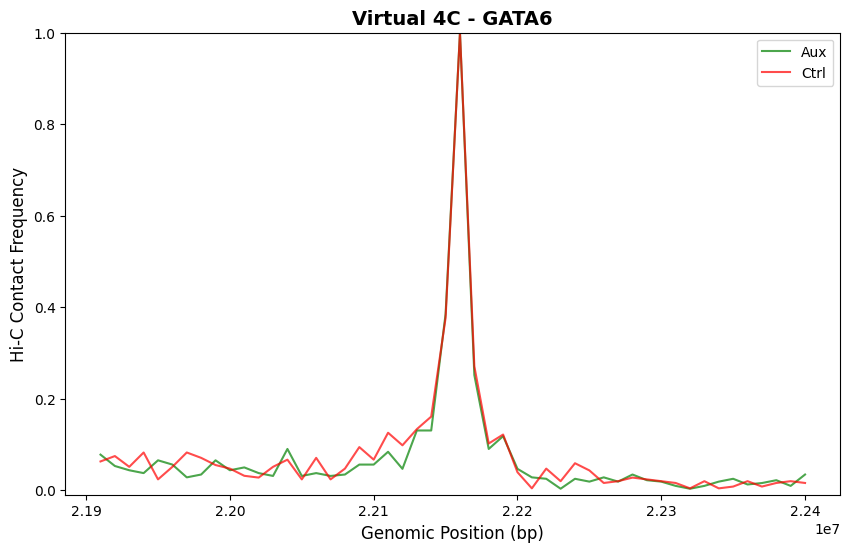

In [10]:
bed_file = "../genome/hg38_promoters.bed"
genes_of_interest = ["GATA6", "CTCF", "MYC"]

# **Extract TSS for target genes**
tss_list = extract_tss_from_bed(bed_file, genes_of_interest)

# **View extraction results**
print(f"Found {len(tss_list)} genes:")
for chrom, start, end, gene in tss_list:
    print(f"  {gene}: {chrom}:{start}-{end}")

# **Plot Hi-C Contact Frequency**
plot_virtual_4C(tss_list, 10000)